## Requirements

In [ ]:
%pip install datasets
%pip install -q bitsandbytes datasets accelerate loralib
%pip install -q git+https://github.com/huggingface/transformers.git@main git+https://github.com/huggingface/peft.git

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 510.5/510.5 kB 8.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 116.3/116.3 kB 11.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 194.1/194.1 kB 8.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 134.8/134.8 kB 9.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 102.2/102.2 MB 6.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 290.1/290.1 kB 24.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 23.7/23.7 MB 45.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 823.6/823.6 kB 38.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 14.1/14.1 MB 58.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 731.7/731.7 MB 1.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 410.6/410.6 MB 2.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 121.6/121.6 MB 8.3 MB/s eta 0:00:00
     ━━━━━━━━━━

## Import libraries

In [ ]:
import transformers
from transformers import GPT2LMHeadModel, GPT2Tokenizer
from peft import LoraConfig, get_peft_model
from datasets import load_dataset, load_metric
import matplotlib.pyplot as plt
import re

import pandas as pd
import torch
import torch.nn as nn

from typing import Tuple, List

model_name = "openai-community/gpt2"
bleu_metric = load_metric("bleu")
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

<ipython-input-2-f564c20dc1f0>:13: FutureWarning: load_metric is deprecated and will be removed in the next major version of datasets. Use 'evaluate.load' instead, from the new library 🤗 Evaluate: https://huggingface.co/docs/evaluate
  bleu_metric = load_metric("bleu")
/usr/local/lib/python3.10/dist-packages/datasets/load.py:756: FutureWarning: The repository for bleu contains custom code which must be executed to correctly load the metric. You can inspect the repository content at https://raw.githubusercontent.com/huggingface/datasets/2.18.0/metrics/bleu/bleu.py
You can avoid this message in future by passing the argument `trust_remote_code=True`.
Passing `trust_remote_code=True` will be mandatory to load this metric from the next major release of `datasets`.
  warnings.warn(


In [ ]:
tokenizer = GPT2Tokenizer.from_pretrained(model_name)
tokenizer.pad_token = tokenizer.eos_token

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:88: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/26.0 [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/1.04M [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/456k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.36M [00:00<?, ?B/s]

config.json:   0%|          | 0.00/665 [00:00<?, ?B/s]

## Data

In [ ]:
dataset = load_dataset("wikitext", "wikitext-2-raw-v1")

Generating test split:   0%|          | 0/4358 [00:00<?, ? examples/s]

Generating train split:   0%|          | 0/36718 [00:00<?, ? examples/s]

Generating validation split:   0%|          | 0/3760 [00:00<?, ? examples/s]

In [ ]:
dataset

DatasetDict({
    test: Dataset({
        features: ['text'],
        num_rows: 4358
    })
    train: Dataset({
        features: ['text'],
        num_rows: 36718
    })
    validation: Dataset({
        features: ['text'],
        num_rows: 3760
    })
})

In [ ]:
dataset['train']['text']

['',
 ' = Valkyria Chronicles III = \n',
 '',
 ' Senjō no Valkyria 3 : Unrecorded Chronicles ( Japanese : 戦場のヴァルキュリア3 , lit . Valkyria of the Battlefield 3 ) , commonly referred to as Valkyria Chronicles III outside Japan , is a tactical role @-@ playing video game developed by Sega and Media.Vision for the PlayStation Portable . Released in January 2011 in Japan , it is the third game in the Valkyria series . Employing the same fusion of tactical and real @-@ time gameplay as its predecessors , the story runs parallel to the first game and follows the " Nameless " , a penal military unit serving the nation of Gallia during the Second Europan War who perform secret black operations and are pitted against the Imperial unit " Calamaty Raven " . \n',
 " The game began development in 2010 , carrying over a large portion of the work done on Valkyria Chronicles II . While it retained the standard features of the series , it also underwent multiple adjustments , such as making the game more f

In [ ]:
'''
clearing data from empty strings and titles
'''
def filter_strings(sample: str) -> str:
    return "= ="  not in sample['text'] and " = "  not in sample['text']


dataset['train'] = dataset['train'].filter(lambda example: example['text'] != "").filter(filter_strings)
dataset['test'] = dataset['test'].filter(lambda example: example['text'] != "").filter(filter_strings)
dataset['validation'] = dataset['validation'].filter(lambda example: example['text'] != "").filter(filter_strings)


data = dataset.map(lambda samples: tokenizer(samples['text']), batched=True)

Filter:   0%|          | 0/36718 [00:00<?, ? examples/s]

Filter:   0%|          | 0/23767 [00:00<?, ? examples/s]

Filter:   0%|          | 0/4358 [00:00<?, ? examples/s]

Filter:   0%|          | 0/2891 [00:00<?, ? examples/s]

Filter:   0%|          | 0/3760 [00:00<?, ? examples/s]

Filter:   0%|          | 0/2461 [00:00<?, ? examples/s]

Map:   0%|          | 0/2176 [00:00<?, ? examples/s]

Map:   0%|          | 0/17532 [00:00<?, ? examples/s]

Map:   0%|          | 0/1841 [00:00<?, ? examples/s]

## Метрика BLEU

In [ ]:
'''
This method of evaluating the model assumes that there are no reference rows in the dataset. In this case, the following algorithm is used:

1. Part of the text is taken from the dataset.
2. The text is divided into two parts:
the first part serves as a hint (prompt) for the model, and the second part is compared with what the model generated.

This approach allows you to evaluate the quality of the model based on the data provided.
'''

def get_references_and_hypotheses(data:DatasetDict, model: GPT2LMHeadModel) -> Tuple[List, List]:
    references = []
    hypotheses = []
    check = 0
    for sample in data:
        index_ = int(len(sample['text'].split())/2)
        references.append(sample['text'].split()[index_:])
        text = sample['text'].split()[:index_]
        text = ' '.join(text)

        batch = tokenizer(text, return_tensors='pt')
        batch = {key: value.to(device) for key, value in batch.items()}
        with torch.no_grad():
            output_tokens = model.generate(**batch, max_new_tokens= len(sample['text'].split())/2, pad_token_id=tokenizer.eos_token_id, use_cache=True)
        generated_text = tokenizer.decode(output_tokens[0][index_:], skip_special_tokens=True)
        hypotheses.append(generated_text.split())
    return references, hypotheses


def get_BLEU_score(dataset: DatasetDict, model: GPT2LMHeadModel) -> float:
  model.to(device)
  references, hypotheses = get_references_and_hypotheses(dataset, model)
  total_score = 0
  for reference, hypothesis in zip(references, hypotheses):
      score = bleu_metric.compute(predictions = [hypothesis], references = [[reference]])
      total_score += score['bleu']

  average_bleu = total_score / len(references)
  print("Average BLEU Score:", average_bleu)
  return average_bleu

# Fine-tuning

In [ ]:
'''
Output information about the number of trained parameters in the model.
'''
def print_trainable_parameters(model: GPT2LMHeadModel) -> None:
    trainable_params = 0
    all_param = 0
    for _, param in model.named_parameters():
        all_param += param.numel()
        if param.requires_grad:
            trainable_params += param.numel()
    print(
        f"trainable params: {trainable_params} || all params: {all_param} || trainable%: {100 * trainable_params / all_param}"
    )

## Full fine-tuning pipeline of GPT2 model on WikiText

In [ ]:
model_FT = GPT2LMHeadModel.from_pretrained(model_name)

model.safetensors:   0%|          | 0.00/548M [00:00<?, ?B/s]

generation_config.json:   0%|          | 0.00/124 [00:00<?, ?B/s]

In [ ]:
trainer_FT = transformers.Trainer(
    model=model_FT,
    train_dataset=data['train'],
    eval_dataset=data['test'],
    args=transformers.TrainingArguments(
        per_device_train_batch_size=4,
        gradient_accumulation_steps=4,
        warmup_steps=50,
        learning_rate=2e-4,
        logging_steps=100,
        num_train_epochs=3,
        output_dir='outputs'
    ),
    data_collator=transformers.DataCollatorForLanguageModeling(tokenizer, mlm=False)
)
model_FT.config.use_cache = False

trainer_FT.train()

Step,Training Loss
100,3.727500
200,3.604600
300,3.529900
400,3.487600
500,3.462300
600,3.443300
700,3.440500
800,3.389200
900,3.374700
1000,3.346200


TrainOutput(global_step=3285, training_loss=3.0796094223788884, metrics={'train_runtime': 3408.908, 'train_samples_per_second': 15.429, 'train_steps_per_second': 0.964, 'total_flos': 6106496855040000.0, 'train_loss': 3.0796094223788884, 'epoch': 3.0})

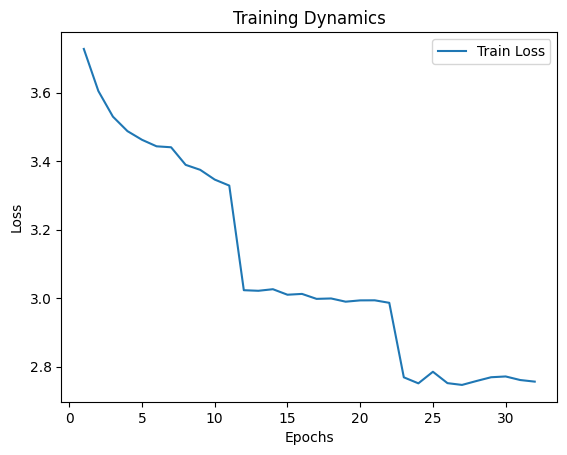

In [ ]:
train_losses = trainer_FT.state.log_history
losses = [entry['loss'] for entry in train_losses if 'loss' in entry]

steps = range(1, len(losses) + 1)
plt.plot(steps, losses, label="Train Loss")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.title("Training Dynamics")
plt.legend()
plt.show()


In [ ]:
model_FT.to(device)
text = "Parameter-efficient fine-tuning of GPT-2 with LoRA"
batch = tokenizer(text, return_tensors='pt')

batch = {key: value.to(device) for key, value in batch.items()}

with torch.cuda.amp.autocast():
    output_tokens = model_FT.generate(**batch, max_new_tokens=50, pad_token_id=tokenizer.eos_token_id, use_cache=True )

generated_text = tokenizer.decode(output_tokens[0], skip_special_tokens=True)
print(generated_text)

Parameter-efficient fine-tuning of GPT-2 with LoRA 

by Paul J. Miller 

Provençal, Switzerland ( September 26, 2008 ) 

A new generation of high @-@ speed transponders, called " transponders ", have been


<b>Note:</b>

* <b>Global step (global_step):</b> The total number of training steps is 3285. The global step is usually tracked to monitor the progress of the model's learning.

* <b>Loss of training (training_loss):</b> The value of learning loss at this stage of learning is 3.0796094223788884. This shows what kind of model loss was achieved at this stage of training.

* <b>Metrics:</b>

  * <b>train_runtime:</b> The training time at this stage was 3408.908 seconds.
  * <b>train_samples_per_second:</b> The model processed approximately 15.429 samples per second.
  * <b>train_steps_per_second:</b> On average, the model performed approximately 0.964 training steps per second.
  * <b>total_flos:</b> The total number of floating point operations performed during training is 6106496855040000.0 (FLOPS - floating point operations per second). This is a metric that allows you to estimate the number of calculations performed by the model.
  * <b>train_loss:</b> The value of the learning loss at this stage is also 3.0796094223788884.

From the data on training time and sample processing speed, it can be concluded that the learning process takes a considerable time, and the sample processing speed is not very high, perhaps this is due to computational limitations or the complexity of the model.

The value of the training loss is high enough, which may indicate that the model does not quite converge yet, and further adjustment of hyperparameters or an increase in the number of training epochs is required.

In [ ]:
# model_FT.save_pretrained('full_tune')

## LoRA fine-tuning pipeline of GPT2 model on WikiText

In [ ]:
model_LoRA = GPT2LMHeadModel.from_pretrained(model_name)

In [ ]:
model_LoRA.base_model

GPT2Model(
  (wte): Embedding(50257, 768)
  (wpe): Embedding(1024, 768)
  (drop): Dropout(p=0.1, inplace=False)
  (h): ModuleList(
    (0-11): 12 x GPT2Block(
      (ln_1): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
      (attn): GPT2Attention(
        (c_attn): Conv1D()
        (c_proj): Conv1D()
        (attn_dropout): Dropout(p=0.1, inplace=False)
        (resid_dropout): Dropout(p=0.1, inplace=False)
      )
      (ln_2): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
      (mlp): GPT2MLP(
        (c_fc): Conv1D()
        (c_proj): Conv1D()
        (act): NewGELUActivation()
        (dropout): Dropout(p=0.1, inplace=False)
      )
    )
  )
  (ln_f): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
)

In [ ]:
for param in model_LoRA.parameters():
  param.requires_grad = False                 # gradients for these parameters will not be calculated during the back propagation of the error
  if param.ndim == 1:
    param.data = param.data.to(torch.float32) # for parameters having the same dimension (param.num == 1),
                                              # their data (param.data) is converted to the torch.float32 type to obtain better results

model_LoRA.gradient_checkpointing_enable()    # reducing memory usage during model training.
model_LoRA.enable_input_require_grads()       # to calculate gradients for the input data of the model.

# converting the output data of the model to the torch.float32 type
class CastOutputToFloat(nn.Sequential):
  def forward(self, x):
    return super().forward(x).to(torch.float32)

model_LoRA.lm_head = CastOutputToFloat(model_LoRA.lm_head)

In [ ]:
config = LoraConfig(
    r=8,
    lora_alpha=8,
    target_modules = ['c_attn', 'c_proj','c_fc'],
    lora_dropout=0.05,
    bias="none",
    task_type="CAUSAL_LM"
)

model_LoRA = get_peft_model(model_LoRA, config)
print_trainable_parameters(model_LoRA)

trainable params: 1179648 || all params: 125619456 || trainable%: 0.939064725769868


/usr/local/lib/python3.10/dist-packages/peft/tuners/lora/layer.py:1059: UserWarning: fan_in_fan_out is set to False but the target module is `Conv1D`. Setting fan_in_fan_out to True.
  warnings.warn(


In [ ]:
model_LoRA.base_model

LoraModel(
  (model): GPT2LMHeadModel(
    (transformer): GPT2Model(
      (wte): Embedding(50257, 768)
      (wpe): Embedding(1024, 768)
      (drop): Dropout(p=0.1, inplace=False)
      (h): ModuleList(
        (0-11): 12 x GPT2Block(
          (ln_1): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
          (attn): GPT2Attention(
            (c_attn): lora.Linear(
              (base_layer): Conv1D()
              (lora_dropout): ModuleDict(
                (default): Dropout(p=0.05, inplace=False)
              )
              (lora_A): ModuleDict(
                (default): Linear(in_features=768, out_features=8, bias=False)
              )
              (lora_B): ModuleDict(
                (default): Linear(in_features=8, out_features=2304, bias=False)
              )
              (lora_embedding_A): ParameterDict()
              (lora_embedding_B): ParameterDict()
            )
            (c_proj): lora.Linear(
              (base_layer): Conv1D()
              (lora_d

In [ ]:
trainer_LoRA = transformers.Trainer(
    model=model_LoRA,
    train_dataset=data['train'],
    eval_dataset=data['test'],
    args=transformers.TrainingArguments(
        per_device_train_batch_size=4,
        gradient_accumulation_steps=4,
        warmup_steps=10,
        learning_rate=2e-4,
        logging_steps=100,
        output_dir='outputs',
        num_train_epochs=3,
    ),
    data_collator=transformers.DataCollatorForLanguageModeling(tokenizer, mlm=False)
)
model_LoRA.config.use_cache = False

trainer_LoRA.train()

Step,Training Loss
100,3.940900
200,3.699200
300,3.624900
400,3.589800
500,3.565500
600,3.560500
700,3.563200
800,3.525600
900,3.529600
1000,3.507300


Step,Training Loss
100,3.940900
200,3.699200
300,3.624900
400,3.589800
500,3.565500
600,3.560500
700,3.563200
800,3.525600
900,3.529600
1000,3.507300


TrainOutput(global_step=3285, training_loss=3.5249088095747716, metrics={'train_runtime': 3743.0335, 'train_samples_per_second': 14.052, 'train_steps_per_second': 0.878, 'total_flos': 6191188314808320.0, 'train_loss': 3.5249088095747716, 'epoch': 3.0})

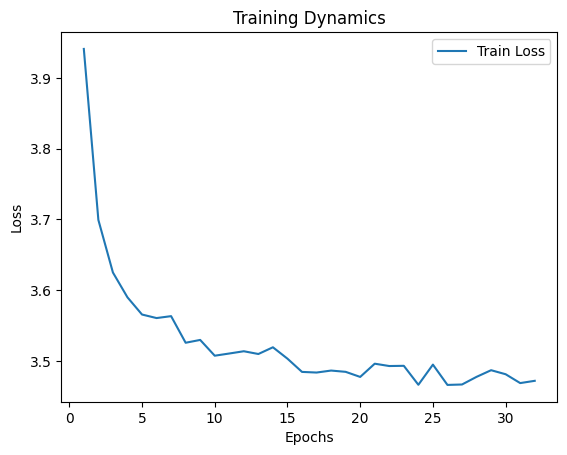

In [ ]:
train_losses = trainer_LoRA.state.log_history
losses = [entry['loss'] for entry in train_losses if 'loss' in entry]

steps = range(1, len(losses) + 1)
plt.plot(steps, losses, label="Train Loss")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.title("Training Dynamics")
plt.legend()
plt.show()

In [ ]:
model_LoRA.to(device)

text = "Parameter-efficient fine-tuning of GPT-2 with LoRA"
batch = tokenizer(text, return_tensors='pt')

batch = {key: value.to(device) for key, value in batch.items()}

with torch.cuda.amp.autocast():
    output_tokens = model_LoRA.generate(**batch, max_new_tokens=50, pad_token_id=tokenizer.eos_token_id, use_cache=True )

generated_text = tokenizer.decode(output_tokens[0], skip_special_tokens=True)
print(generated_text)

`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...
/usr/local/lib/python3.10/dist-packages/torch/utils/checkpoint.py:90: UserWarning: None of the inputs have requires_grad=True. Gradients will be None
  warnings.warn(


Parameter-efficient fine-tuning of GPT-2 with LoRA is a key to the development of the GPT system. The GPT is a system of linear and nonlinear equations that are used to calculate the energy density of the system. The GPT is a system of linear and nonlinear equations that are


<b>Note:</b>

* <b>Global step (global_step):</b> The total number of training steps is 3285.
* <b>Loss of training (training_loss):</b> The value of learning loss at this stage of learning is 3.5249088095747716.
* <b>Metrics:</b>
  * <b>train_runtime:</b> The training time at this stage was 3743.0335 seconds.
  * <b>train_samples_per_second:</b> The model processed approximately 14.052 samples per second.
  * <b>train_steps_per_second:</b> On average, the model performed approximately 0.888 training steps per second.
  * <b> total_flos:</b> The total number of floating point operations performed during training is 6191188314808320.0 (FLOPS - floating point operations per second). This is a metric that allows you to estimate the number of calculations performed by the model.
  * <b>train_loss:</b> The learning loss value at this stage is also 3.5249088095747716.

From the data on training time and sample processing speed, it can be concluded that the learning process takes a considerable time, and the sample processing speed is not very high, perhaps this is due to computational limitations or the complexity of the model.

The value of the training loss is high enough, which may indicate that the model does not quite converge yet, and further adjustment of hyperparameters or an increase in the number of training epochs is required.

## Performance comparison of full fine-tuning and LoRA-based one (BLEU score)

In [ ]:
result_bleu = {}

model_origin = GPT2LMHeadModel.from_pretrained(model_name)
result_bleu['origin'] = get_BLEU_score(dataset['validation'], model_origin)

result_bleu['full'] = get_BLEU_score(dataset['validation'], model_FT)
result_bleu['LoRA'] = get_BLEU_score(dataset['validation'], model_LoRA)


Average BLEU Score: 0.0
Average BLEU Score: 0.0
Average BLEU Score: 0.001258885698671932


In [ ]:
df_result_bleu = pd.DataFrame(result_bleu, index = ['BLEU']).T

In [ ]:
df_result_bleu

,BLEU
origin,0.000000
full,0.000000
LoRA,0.001259


,BLEU
origin,0.000000
full,0.000000
LoRA,0.001259


<b>Note:</b>

* <b>Training area (training_loss):</b>

   * Model with full tunning: 3.0796094223788884

   * Model with LoRA: 3.5249088095747716

  Model with full tunning has a lower learning loss, which may indicate better model performance during training. However, learning loss is not always the only indicator of model quality, and other metrics must also be taken into account.
  </p>

* <b>BLEU Score:</b>
  * Model with full tunning: 0
  * Model with LoRA: 0.001259

  Model with LoRA shows a small but non-zero BLEU score value, while Model with full tunning has a BLEU score value of 0. This may indicate that Model with LoRA gives slightly better results in evaluating the quality of the generated text.

* <b>Learning rate (train_samples_per_second):</b>
  * Model with full tunning:  15.429 samples per second
  * Model with LoRA: 14.052 samples per second

  Model with full tunning also shows a slightly higher sample processing rate per second, which can be an important factor, especially when training on large amounts of data.


Overall, although Model with full tunning has lower learning loss and higher sample processing speed, Model with LoRA has shown a slight improvement in BLEU estimation, which may indicate some advantages in the quality of text generation.